In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, classification_report

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
dataset, dataset_info = tfds.load('malaria', with_info = True, as_supervised = True, shuffle_files=True, split=['train'])

In [7]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [4]:
def splits_function(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

    val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
    val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

    test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

    return train_dataset, val_dataset, test_dataset

In [23]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
# dataset = tf.data.Dataset.range(10)

train_dataset, val_dataset, test_dataset = splits_function(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print(f'train_dataset : {list(train_dataset.take(1).as_numpy_iterator())}')
print(f'val_dataset : {list(val_dataset.take(1).as_numpy_iterator())}')
print(f'test_dataset : {list(test_dataset.take(1).as_numpy_iterator())}')

train_dataset : [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)]
val_dataset : [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0

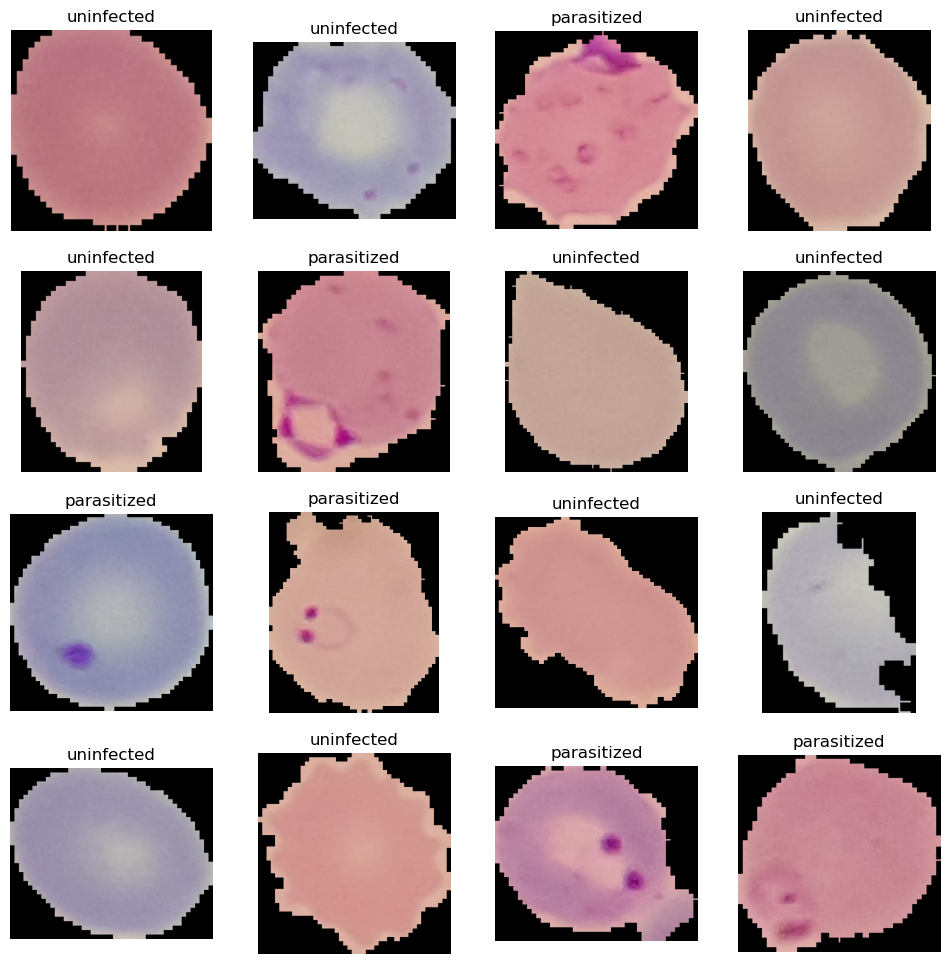

In [6]:
plt.figure(figsize = (12,12))
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

In [7]:
IM_SIZE = 224
def resizing_rescale(image, label):
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0
    return image, label

In [25]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

In [27]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [43]:
leNet_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    tf.keras.layers.Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2),

    tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(1000, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1, activation = 'sigmoid'),

    # tf.keras.layers.Dense(128, activation = 'relu'),
    # tf.keras.layers.Dense(128, activation = 'relu'),
    # tf.keras.layers.Dense(128, activation = 'relu'),
    # tf.keras.layers.Dense(1)
])

leNet_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 6)    │           168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 222, 222, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 109, 109, 16)   │           880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 109, 109, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 46656)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │    46,657,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1000)           │         4,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │       100,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,762,737 (178.39 MB)

 Trainable params: 46,760,493 (178.38 MB)

 Non-trainable params: 2,244 (8.77 KB)

In [45]:
leNet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
                    loss = tf.keras.losses.BinaryCrossentropy(),
                    metrics = ['accuracy'])

In [ ]:
history = leNet_model.fit(train_dataset, validation_data = val_dataset, epochs = 20, verbose = 1)

Epoch 1/20
 29/689 ━━━━━━━━━━━━━━━━━━━━ 7:11 654ms/step - accuracy: 0.5671 - loss: 0.9756

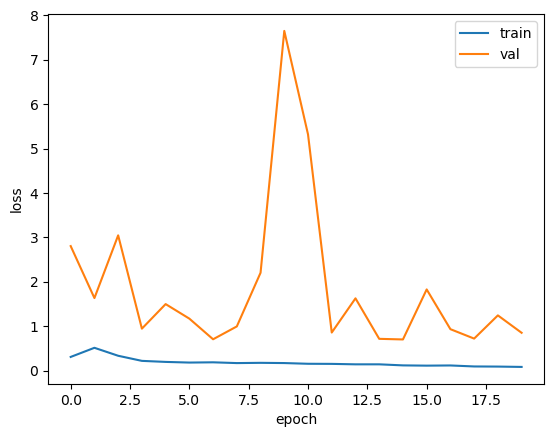

In [13]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

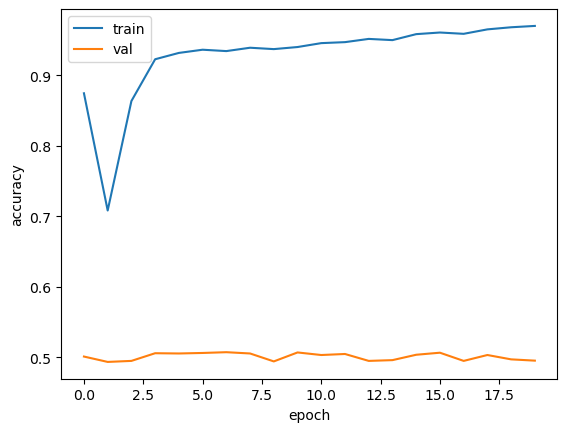

In [14]:
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'])
plt.show()

In [31]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [29]:
test_dataset = test_dataset.batch(1)

In [17]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [33]:
leNet_model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9232 - loss: 0.3200


[0.33734411001205444, 0.9252811074256897]

In [35]:
leNet_model.predict(test_dataset.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


0.9999439

In [37]:
def parasite_or_not(x):
    if x > 0.5:
        return str('Parasite')
    else:
        return str('Not Parasite')

In [39]:
parasite_or_not(leNet_model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'Not Parasite'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


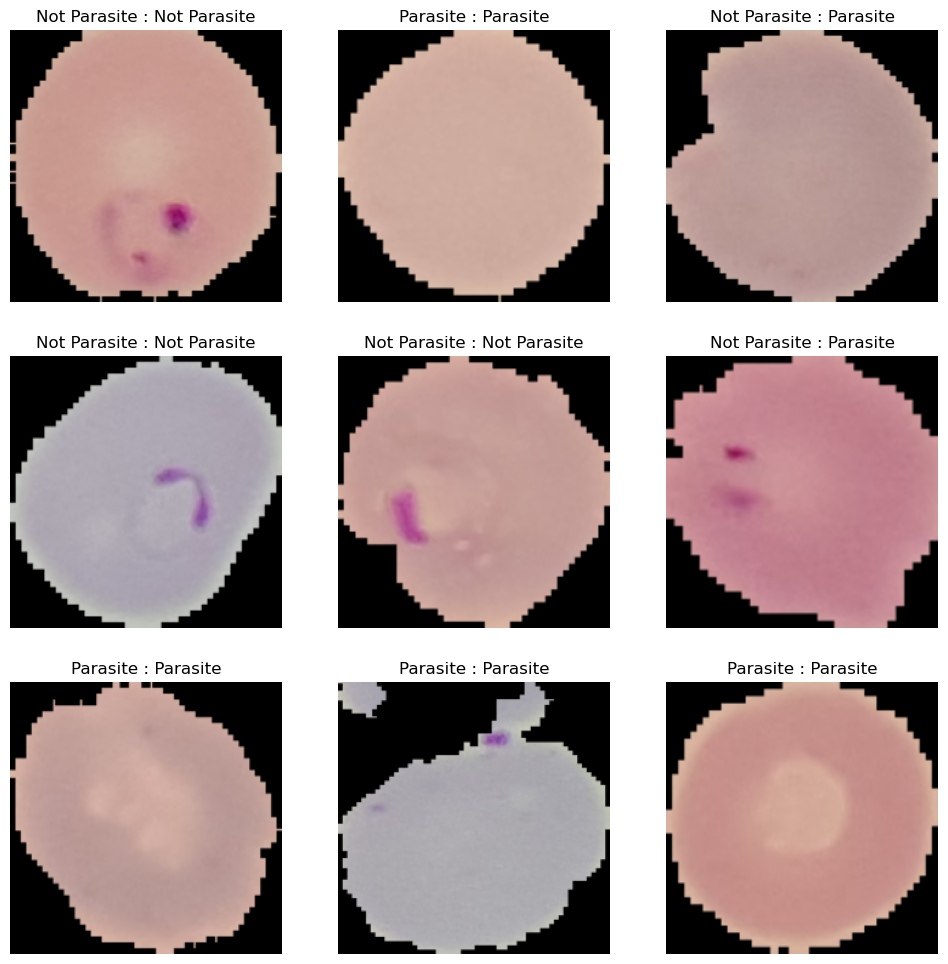

In [41]:
plt.figure(figsize = (12,12))
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0])
    plt.title( str(parasite_or_not(label.numpy()[0])) + ' : ' + str(parasite_or_not(leNet_model.predict(image)[0][0])))
    plt.axis('off')